In [1]:
!pip install pandas scikit-learn matplotlib

import pandas as pd
import numpy as np 
import re
from datetime import datetime 
import ast
from collections import Counter
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import geopandas as gpd
from scipy.stats import ttest_ind
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
#from pysal.lib.weights import KNN
#from pysal.explore import esda
!pip install urbanaccess pandana

     ---------------------------------------- 48.9/48.9 kB 2.4 MB/s eta 0:00:00
     -------------------------------------- 141.6/141.6 kB 8.2 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 7.6 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 7.0 MB/s eta 0:00:00
     ---------------------------------------- 6.1/6.1 MB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 22.9/22.9 MB 6.3 MB/s eta 0:00:00


In [2]:

#file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Data/2. airbnb_data/Paris/Paris all detailed listings/Paris_Q1_detailed_listings.xlsx'
#recsv'

#insert file_path for the data
file_path = 'H:/Documents/Paris/Paris/Paris all detailed listings/Paris_Q1_detailed_listings.xlsx'
#read data, and quickly check if it is correctly read in
dataframe1= pd.read_excel(file_path)


In [3]:
#decided which columns will not be relevant for the first initial analysis
columns_to_drop =["name","description","host_location","host_thumbnail_url","host_name","bathrooms",
                  "listing_url","scrape_id","last_scraped", "host_picture_url","host_url", "host_has_profile_pic", 
                  "host_verifications","source","calendar_last_scraped","license","picture_url","host_about",
                             "neighbourhood","neighbourhood_group_cleansed","minimum_minimum_nights",
                             "maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights",
                             "minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated",
                             "neighborhood_overview","host_neighbourhood", "host_acceptance_rate"]
dataframe1 = dataframe1.drop(columns_to_drop, axis=1)

#solving trailing white space problem
string_columns = dataframe1.select_dtypes(include='object').columns.tolist()
for i in string_columns:
    dataframe1[i] = dataframe1[i].str.strip()

#missing values have always been checked during this cleaning with the function: print(dataframe1.isnull().mean()) 

#host_repsonse_time, filling in the empty ones with "unknown"
dataframe1.host_response_time.fillna("unknown", inplace=True)
dataframe1.host_response_time.value_counts(normalize=True)

#adapting the host_response_rate column to better fit
# Removing the % sign from the host_response_rate string and converting to an integer
dataframe1.host_response_rate = dataframe1.host_response_rate.str[:-1].astype('float64')
# Bin into four categories
dataframe1.host_response_rate = pd.cut(dataframe1.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
# Converting to string
dataframe1.host_response_rate = dataframe1.host_response_rate.astype('str')
# Replace nulls with 'unknown'
dataframe1.host_response_rate.replace('nan', 'unknown', inplace=True)

#these rows do not have that big of a missing value amount so we just delete the missing value rows here
col = ["host_since","host_identity_verified","host_listings_count","host_total_listings_count","host_is_superhost"]
for column in col:
    dataframe1.dropna(subset=[column], inplace=True)

# Category counts
dataframe1.host_response_rate.value_counts()
#fill out all NaN within string columns with ''
for column in string_columns:
    dataframe1[column] = dataframe1[column].fillna("")   

#fixing the "bathroom_text" column to only numbers and renaming it
def extract_numeric(value):
    numeric_part = re.search(r'\d+\.\d+|\d+', str(value))
    return float(numeric_part.group()) if numeric_part else None
dataframe1['bathrooms_text'] = dataframe1['bathrooms_text'].apply(extract_numeric)
dataframe1.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

#adding a column with the information if a listing has a review or not
dataframe1['zero_reviews'] = dataframe1['number_of_reviews'] == 0
    
#delete those that have no information about both beds and bedrooms
dataframe1.dropna(subset=['beds', 'bedrooms'], how='all', inplace=True)

#dropping those with +4 bedrooms (outliers) and no information about bedroom and between 1-4 beds is a studio so 0 bedrooms
dataframe1.loc[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'].between(1, 4)), 'bedrooms'] = 0
dataframe1.drop(dataframe1[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'] > 4)].index, inplace=True)

#fill in all the other empty values with the amount of bedrooms 
dataframe1['beds'].fillna(dataframe1['bedrooms'], inplace=True)

#dropping those that still have no bedroom amount 
dataframe1.dropna(subset=["bedrooms"], inplace=True)

#dropping those that still have no bathroom amount 
dataframe1.dropna(subset=["bathrooms"], inplace=True)

dataframe1['first_review'] = pd.to_datetime(dataframe1['first_review']) 
# Calculating the number of days
dataframe1['days_since_first_review'] = (datetime(2024, 1, 20) - dataframe1['first_review']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_first_review'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_first_first_review'] = pd.qcut(dataframe1['days_since_first_review'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

dataframe1['last_review'] = pd.to_datetime(dataframe1['last_review']) 
# Calculating the number of days
dataframe1['days_since_last_review'] = (datetime(2024, 1, 20) - dataframe1['last_review']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_last_review'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_last_last_review'] = pd.qcut(dataframe1['days_since_last_review'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

dataframe1['host_since'] = pd.to_datetime(dataframe1['host_since']) 
# Calculating the number of days
dataframe1['days_since_host'] = (datetime(2024, 1, 20) - dataframe1['host_since']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_host'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_host_host'] = pd.qcut(dataframe1['days_since_host'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

#Simplifying the property_types in to 4 categories
dataframe1.property_type.replace({
    'Barn': 'House',
    'Boat': 'Other',
    'Bus': 'Other',
    'Camper/RV': 'Other',
    'Casa particular': 'House',
    'Cave': 'Other',
    'Dome': 'Other',
    'Earthen home': 'House',
    'Entire bed and breakfast': 'Hotel',    
    'Entire bungalow': 'House',
    'Entire condo': 'Apartmen',
    'Entire guesthouse': 'House',
    'Entire home': 'House',
    'Entire guest suite': 'Apartment',
    'Entire rental unit': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire home/apt': 'House',
    'Entire place': 'House',
    'Entire serviced apartment': 'Apartment',
    'Entire townhouse': 'House',
    'Entire villa': 'House',
    'Entire vacation home': 'House',
    'Floor': 'Other',
    'Houseboat': 'Other',
    'Private room': 'Apartment',
    'Island': 'Other',
    'Private room in bed and breakfast': 'Hotel',    
    'Private room in boat': 'Other',
    'Private room in casa particular': 'House',
    'Private room in condo': 'Apartment',
    'Private room in guest suite': 'Apartment',
    'Private room in earthen home': 'House',
    'Private room in home': 'House',
    'Private room in guesthouse': 'House',
    'Private room in loft': 'Apartment',
    'Private room in hostel': 'Hotel',
    'Private room in rental unit': 'Apartment',
    'Private room in townhouse': 'House',
    'Private room in tiny home': 'House',
    'Private room in serviced apartment': 'Apartment',
    'Room in bed and breakfast': 'Hotel',
    'Private room in villa': 'House',
    'Room in serviced apartment': 'Apartment',
    'Room in boutique hotel': 'Hotel',
    'Room in hotel': 'Hotel',
    'Room in hostel': 'Hotel',
    'Shared room in bed and breakfast': 'Hotel',
    'Shared room in boutique hotel': 'Hotel',
    'Shared room in cabin': 'Other',
    'Shared room in boat': 'Other',
    'Shared room in condo': 'Apartment',
    'Shared room in farm stay': 'Other',
    'Shared room in guesthouse': 'House',
    'Shared room in casa particular': 'House',
    'Shared room in ice dome': 'Other',
    'Shared room in home': 'House',
    'Shared room in hostel': 'Hotel',
    'Shared room in hotel': 'Hotel',
    'Shared room in rental unit': 'Apartment',
    'Tiny home': 'House',
    'Shared room in loft': 'Apartment',
    'Shared room in townhouse': 'House',
    'Shared room in tiny home': 'House',
    }, inplace=True)

# Replacing other categories with 'other'
dataframe1.loc[~dataframe1.property_type.isin(['House', 'Apartment','Hotel']), 'property_type'] = 'Other'
#dataframe1['property_type'].value_counts()

#changing the name from neighbourhoud_cleansed to neighbourhood
dataframe1.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

#convert the necessary columns to a boolean type, which is easier to use
columns_to_convert = ['host_is_superhost', 'instant_bookable', 'host_identity_verified',"has_availability"] 
for column in columns_to_convert:
    dataframe1[column] = dataframe1[column].replace({'f': False, 't': True}).astype(bool)

In [4]:
# Convert the string representation of lists to actual lists
dataframe1["amenities"] = dataframe1["amenities"].apply(ast.literal_eval)

In [5]:
dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56170 entries, 0 to 56725
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            56170 non-null  int64         
 1   host_id                                       56170 non-null  int64         
 2   host_since                                    56170 non-null  datetime64[ns]
 3   host_response_time                            56170 non-null  object        
 4   host_response_rate                            56170 non-null  object        
 5   host_is_superhost                             56170 non-null  bool          
 6   host_listings_count                           56170 non-null  float64       
 7   host_total_listings_count                     56170 non-null  float64       
 8   host_identity_verified                        56170 non-null  bool

In [6]:
#making a unique list out of all the different kind of amenities that there are
unique_items_set = set.union(*dataframe1["amenities"].apply(set))
print(unique_items_set)
print(len(unique_items_set)) #first we come to  5829 different amenities
#the one that is shown here is taken after the adjustments you can see below

{'Scholtes  oven', 'Liebehr refrigerator', 'Smeg oven', 'Via TV sound system', 'TV with Netflix, Amazon Prime Video', 'TIVOLI sound system with Bluetooth and aux', '25" HDTV with Netflix, Chromecast', 'Acor  refrigerator', 'Azzaro shampoo', 'Marshal sound system', 'Brandt gas stove', '40" HDTV with Netflix, Chromecast, premium cable, standard cable', 'Clothing storage: closet and walk-in closet', '20" HDTV with Chromecast, standard cable', 'Sholtes stainless steel oven', 'L oreal shampoo', '55" HDTV with Apple TV, Netflix', 'Indoor fireplace: ethanol', 'Dop cadum body soap', 'Plaques induction SAUTER induction stove', 'De Dietrich induction stove', 'Zanussi refrigerator', 'Samsung stainless steel induction stove', 'Whirpool  refrigerator', '70" HDTV', 'Sample shampoo', 'Boose  Bluetooth sound system', 'TV with Chromecast, Disney+, Netflix, premium cable, standard cable', 'JBL Go 2 Bluetooth sound system', 'Faure stove', 'Aucune idee oven', 'L’Oreal  shampoo', 'LES CHOSE SIMPLES shampoo

In [7]:
#with the code down below we will simplify the amenities to reduce the amount of amenities

oven_items_set = {item for item in unique_items_set if 'oven' in item.lower()}
def replace_oven_items(item_list):
    return ['oven' if item in oven_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_oven_items)

soap_items_set = {item for item in unique_items_set if 'soap' in item.lower()}
def replace_soap_items(item_list):
    return ['soap' if item in soap_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_soap_items)

shampoo_items_set = {item for item in unique_items_set if 'shampoo' in item.lower()}
def replace_shampoo_items(item_list):
    return ['shampoo' if item in shampoo_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_shampoo_items)

wifi_items_set = {item for item in unique_items_set if 'wifi' in item.lower()}
def replace_wifi_items(item_list):
    return ['wifi' if item in wifi_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_wifi_items)

special_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['Netflix', 'Disney+', 'Amazon Prime'])}
def replace_and_add_broadcast(item_list):
    # Replace items from special_items_set with 'Broadcast'
    item_list = ['broadcast' if item in special_items_set else item for item in item_list]
    # Add 'TV' to the list if modified
    modified = any(item == 'broadcast' for item in item_list)
    if modified:
        item_list.append('TV')
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_and_add_broadcast)

tv_items_set = {item for item in unique_items_set if 'tv' in item.lower()}
def replace_tv_items(item_list):
    return ['tv' if item in tv_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_tv_items)

ref_items_set = {item for item in unique_items_set if 'refrigerator' in item.lower()}
def replace_ref_items(item_list):
    return ['refrigerator' if item in ref_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_ref_items)

coffee_items_set = {item for item in unique_items_set if 'coffee' in item.lower()}
def replace_coffee_items(item_list):
    return ['coffee' if item in coffee_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_coffee_items)

sound_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['sound system', 'Bluetooth'])}
def replace_sound_items(item_list):
    item_list = ['sound system' if item in sound_items_set else item for item in item_list]
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_sound_items)

stove_items_set = {item for item in unique_items_set if 'stove' in item.lower()}
def replace_stove_items(item_list):
    return ['stove' if item in stove_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_stove_items)

cond_items_set = {item for item in unique_items_set if 'conditioner' in item.lower()}
def replace_cond_items(item_list):
    return ['conditioner' if item in cond_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_cond_items)

park_items_set = {item for item in unique_items_set if 'parking' in item.lower()}
def replace_park_items(item_list):
    return ['parking' if item in park_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_park_items)

clothing_items_set = {item for item in unique_items_set if 'clothing storage' in item.lower()}
def replace_clothing_items(item_list):
    return ['clothing storage' if item in clothing_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_clothing_items)

exercise_items_set = {item for item in unique_items_set if 'exercise equipment' in item.lower()}
def replace_exercise_items(item_list):
    return ['exercise equipment' if item in exercise_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_exercise_items)

children_items_set = {item for item in unique_items_set if 'children' in item.lower()}
def replace_children_items(item_list):
    return ['toys children' if item in children_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_children_items)

bbq_items_set = {item for item in unique_items_set if 'bbq' in item.lower()}
def replace_bbq_items(item_list):
    return ['bbq' if item in bbq_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_bbq_items)

pool_items_set = {item for item in unique_items_set if 'pool' in item.lower()}
def replace_pool_items(item_list):
    return ['pool' if item in pool_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_pool_items)

hot_items_set = {item for item in unique_items_set if 'hot tub' in item.lower()}
def replace_hot_items(item_list):
    return ['hot tub' if item in hot_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_hot_items)

backyard_items_set = {item for item in unique_items_set if 'backyard' in item.lower()}
def replace_backyard_items(item_list):
    return ['backyard' if item in backyard_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_backyard_items)

gym_items_set = {item for item in unique_items_set if 'gym' in item.lower()}
def replace_gym_items(item_list):
    return ['gym' if item in gym_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gym_items)

view_items_set = {item for item in unique_items_set if 'view' in item.lower()}
def replace_view_items(item_list):
    return ['view' if item in view_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_view_items)

crib_items_set = {item for item in unique_items_set if 'crib' in item.lower()}
def replace_crib_items(item_list):
    return ['crib' if item in crib_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_crib_items)

gc_items_set = {item for item in unique_items_set if 'game console' in item.lower()}
def replace_gc_items(item_list):
    return ['game console' if item in gc_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gc_items)

In [8]:
#last step to clean the amenities is removing the ones that do not appear 1000 times or more in the column
flat_list = [word for sublist in dataframe1["amenities"] for word in sublist]
word_counts = Counter(flat_list)
filtered_word_set = {word for word, count in word_counts.items() if count < 1000}
common_elements = list(filtered_word_set & unique_items_set)

def remove_common_elements(item_list):
    return [item for item in item_list if item not in common_elements]
dataframe1['amenities'] = dataframe1['amenities'].apply(remove_common_elements)

#only 94 unique items left, which is an acceptable amount and now we can make columns out of these ones

In [9]:
#making a unique list out of all the different kind of amenities that there are
unique_items_set = set.union(*dataframe1["amenities"].apply(set))
print(unique_items_set)
print(len(unique_items_set)) #first we come to  5829 different amenities
#the one that is shown here is taken after the adjustments you can see below

{'Bathtub', 'Cooking basics', 'Extra pillows and blankets', 'Toaster', 'Radiant heating', 'Private entrance', 'Outdoor dining area', 'Carbon monoxide alarm', 'Security cameras on property', 'Essentials', 'Outdoor furniture', 'Rice maker', 'coffee', 'stove', 'soap', 'oven', 'toys children', 'Free washer – In unit', 'Blender', 'hot tub', 'Kitchen', 'Bread maker', 'parking', 'Indoor fireplace', 'Washer', 'Private patio or balcony', 'Shower gel', 'Long term stays allowed', 'Luggage dropoff allowed', 'refrigerator', 'Breakfast', 'Hot water kettle', 'Building staff', 'Host greets you', 'sound system', 'Self check-in', 'First aid kit', 'Sound system', 'Ethernet connection', 'Iron', 'Dishes and silverware', 'view', 'shampoo', 'Drying rack for clothing', 'Hot water', 'Dining table', 'Board games', 'wifi', 'gym', 'game console', 'Portable heater', 'Hair dryer', 'Safe', 'Room-darkening shades', 'Lock on bedroom door', 'Portable fans', 'Free dryer – In unit', 'Laundromat nearby', 'Microwave', 'Bab

In [10]:
#making new columns for the amenities indivually with a 0 or 1 inside of them 
for item in unique_items_set:
    dataframe1[item] = dataframe1["amenities"].apply(lambda x: int(item in x))

C:\Users\r0801774\AppData\Local\Temp\ipykernel_11744\2389720884.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe1[item] = dataframe1["amenities"].apply(lambda x: int(item in x))
C:\Users\r0801774\AppData\Local\Temp\ipykernel_11744\2389720884.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe1[item] = dataframe1["amenities"].apply(lambda x: int(item in x))
C:\Users\r0801774\AppData\Local\Temp\ipykernel_11744\2389720884.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

In [11]:
#now we will be able to remove the 'amenities' column
dataframe1 = dataframe1.drop('amenities', axis=1)

In [12]:
# Calculate the total number of amenities for each listing and make this a new column
dataframe1['total_amenities'] = dataframe1.iloc[:, 51:-1].sum(axis=1)

C:\Users\r0801774\AppData\Local\Temp\ipykernel_11744\1558963774.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe1['total_amenities'] = dataframe1.iloc[:, 51:-1].sum(axis=1)


In [13]:
dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56170 entries, 0 to 56725
Columns: 146 entries, id to total_amenities
dtypes: bool(5), category(3), datetime64[ns](3), float64(17), int64(113), object(5)
memory usage: 60.0+ MB


In [14]:
#with the following code we are going to eliminate the outliers regarding the columns: bedrooms, beds and bathrooms

x = "bedrooms"

# Calculate the percentage of each bedroom count relative to all listings
bedrooms_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Identify bedroom counts with percentage <= 0.01%
bedrooms_to_drop = bedrooms_percentage[bedrooms_percentage <= 0.01].index

# Drop rows with bedrooms counts <= 0.01%
dataframe1 = dataframe1[~dataframe1[x].isin(bedrooms_to_drop)]

# Display the percentage of each bedroom count after filtering
filtered_bedroom_percentage = dataframe1[x].value_counts(normalize=True) * 100
for bedrooms, percentage in filtered_bedroom_percentage.items():
    print(f'The percentage of listings with {bedrooms} bedroom(s) is: {percentage:.2f}%')
    
y = "bathrooms"

# Calculate the percentage of each bathroom count relative to all listings
bathrooms_percentage = dataframe1[y].value_counts(normalize=True) * 100

# Identify bathroom counts with percentage <= 0.01%
bathrooms_to_drop = bathrooms_percentage[bathrooms_percentage <= 0.01].index

# Drop rows with bathrooms counts <= 0.01%
dataframe1 = dataframe1[~dataframe1[y].isin(bathrooms_to_drop)]

# Display the percentage of each bathroom count after filtering
filtered_bathroom_percentage = dataframe1[y].value_counts(normalize=True) * 100
for bathrooms, percentage in filtered_bathroom_percentage.items():
    print(f'The percentage of listings with {bathrooms} bathroom(s) is: {percentage:.2f}%')
    
z = "beds"

# Calculate the percentage of each bed count relative to all listings
beds_percentage = dataframe1[z].value_counts(normalize=True) * 100

# Identify bed counts with percentage <= 0.01%
beds_to_drop = beds_percentage[beds_percentage <= 0.01].index

# Drop rows with bed counts <= 0.01%
dataframe1 = dataframe1[~dataframe1[z].isin(beds_to_drop)]

# Display the percentage of each bed count after filtering
filtered_beds_percentage = dataframe1[z].value_counts(normalize=True) * 100
for beds, percentage in filtered_beds_percentage.items():
    print(f'The percentage of listings with {beds} bed(s) is: {percentage:.2f}%')

The percentage of listings with 1.0 bedroom(s) is: 62.33%
The percentage of listings with 0.0 bedroom(s) is: 15.70%
The percentage of listings with 2.0 bedroom(s) is: 15.69%
The percentage of listings with 3.0 bedroom(s) is: 4.81%
The percentage of listings with 4.0 bedroom(s) is: 1.17%
The percentage of listings with 5.0 bedroom(s) is: 0.22%
The percentage of listings with 6.0 bedroom(s) is: 0.06%
The percentage of listings with 7.0 bedroom(s) is: 0.02%
The percentage of listings with 50.0 bedroom(s) is: 0.01%
The percentage of listings with 1.0 bathroom(s) is: 86.00%
The percentage of listings with 2.0 bathroom(s) is: 6.14%
The percentage of listings with 1.5 bathroom(s) is: 5.38%
The percentage of listings with 2.5 bathroom(s) is: 1.11%
The percentage of listings with 3.0 bathroom(s) is: 0.77%
The percentage of listings with 0.0 bathroom(s) is: 0.22%
The percentage of listings with 3.5 bathroom(s) is: 0.15%
The percentage of listings with 4.0 bathroom(s) is: 0.11%
The percentage of 

In [15]:
print(dataframe1.head())

     id  host_id host_since host_response_time host_response_rate  \
0  5396     7903 2009-02-14     within an hour               100%   
1  7397     2626 2008-08-30     within an hour               100%   
2  7964    22155 2009-06-18            unknown            unknown   
3  9359    28422 2009-07-29            unknown            unknown   
4  9952    33534 2009-08-24     within an hour               100%   

   host_is_superhost  host_listings_count  host_total_listings_count  \
0              False                  1.0                        1.0   
1               True                  3.0                        9.0   
2              False                  1.0                        1.0   
3              False                  2.0                        4.0   
4               True                  1.0                        1.0   

   host_identity_verified   neighbourhood  ...  Cleaning products  Dishwasher  \
0                    True  Hôtel-de-Ville  ...                  1      

In [16]:
# Creating a copy of the dataset to work with
data_copy = dataframe1.copy()
#looking into which columns currently still have empty values
columns_with_nan = data_copy.columns[data_copy.isna().any()].tolist()
# Print the columns
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'days_since_first_review', 'days_since_first_first_review', 'days_since_last_review', 'days_since_last_last_review']


In [17]:
columns_to_drop = ["id", "host_id", "days_since_host_host","host_since"]
data_copy = data_copy.drop(columns_to_drop, axis=1)

In [18]:
# Display columns with datetime type
datetime_columns = data_copy.select_dtypes(include=['datetime64[ns]']).columns
print("Datetime Columns:", datetime_columns.tolist())

Datetime Columns: ['first_review', 'last_review']


In [19]:
#to many missing values in these columns, thus removing them
columns_to_drop = ['first_review', 'last_review','days_since_first_review', 'days_since_first_first_review', 'days_since_last_review', 
                   'days_since_last_last_review']

#filling in 0 in the fields where nothing is filled in
columns_to_fill = ['review_scores_rating', 'review_scores_accuracy', 
                   'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                   'review_scores_location', 'review_scores_value', 'reviews_per_month']

# Fill NaN values with 0 in the specified columns
for column in columns_to_fill:
    data_copy[column] = data_copy[column].fillna(0)

data_copy_clean = data_copy.drop(columns_to_drop, axis=1)

#looking into which columns currently still have empty values
columns_with_nan = data_copy_clean.columns[data_copy_clean.isna().any()].tolist()
# Print the columns
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [20]:
print(data_copy.head())

  host_response_time host_response_rate  host_is_superhost  \
0     within an hour               100%              False   
1     within an hour               100%               True   
2            unknown            unknown              False   
3            unknown            unknown              False   
4     within an hour               100%               True   

   host_listings_count  host_total_listings_count  host_identity_verified  \
0                  1.0                        1.0                    True   
1                  3.0                        9.0                    True   
2                  1.0                        1.0                    True   
3                  2.0                        4.0                    True   
4                  1.0                        1.0                    True   

    neighbourhood  latitude  longitude property_type  ... Cleaning products  \
0  Hôtel-de-Ville  48.85247    2.35835     Apartment  ...                 1   
1  Hôt

In [21]:
data_copy_clean.info

<bound method DataFrame.info of       host_response_time host_response_rate  host_is_superhost  \
0         within an hour               100%              False   
1         within an hour               100%               True   
2                unknown            unknown              False   
3                unknown            unknown              False   
4         within an hour               100%               True   
...                  ...                ...                ...   
56721     within an hour               100%              False   
56722     within an hour               100%              False   
56723     within an hour             90-99%              False   
56724     within an hour               100%              False   
56725     within an hour               100%              False   

       host_listings_count  host_total_listings_count  host_identity_verified  \
0                      1.0                        1.0                    True   
1            

In [22]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Splitting the columns up in one-hot and label encoding
categorical_columns_one_hot = ['neighbourhood', 'property_type', 'room_type']  # For one-hot encoding
categorical_columns_label = ['host_response_time', 'host_response_rate']  # For label encoding

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(data_copy_clean[categorical_columns_one_hot])

# Manually create feature names for the one-hot encoded columns
one_hot_feature_names = []
for i, column in enumerate(categorical_columns_one_hot):
    categories = one_hot_encoder.categories_[i]
    one_hot_feature_names.extend([f"{column}_{category}" for category in categories])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names, index=data_copy_clean.index)

# Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns_label:
    data_copy_clean[col] = label_encoder.fit_transform(data_copy_clean[col])

# Concatenate the one-hot encoded columns back to the original dataframe
data_copy_clean = pd.concat([data_copy_clean, one_hot_encoded_df], axis=1)

# Drop the original string columns
data_copy_clean.drop(categorical_columns_one_hot, axis=1, inplace=True)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
#cap all the outliers (the ones that are below 0.05 or above 0.95 percentile) to 0.05 percentile and 0.95 percentile
from scipy.stats.mstats import winsorize
for col in data_copy_clean.select_dtypes(include=np.number).columns:
    data_copy_clean[col] = winsorize(data_copy_clean[col], limits=[0.05, 0.05])

Mean Squared Error: 3798.632395881432
R^2 Score: 0.6136667903326081
Coefficients: [ 4.98348368e-01 -1.66288544e+00  1.32078391e+01 -1.96963922e-02
 -1.17044676e-02  1.34615170e+00  1.31688139e+01  5.28676710e+01
  2.46974141e+01  3.08750963e+00 -8.78310730e-02 -1.04134213e+01
 -1.37024072e-01  1.23940674e+00 -3.39485443e-01  3.58535888e-02
 -1.55072184e-01  7.29411947e-01 -6.28450373e+00  1.04728581e+01
 -3.80398193e+00  1.07890933e+01 -7.87252823e+00 -5.67417136e+00
  5.05868808e+00 -1.01367011e+01  1.19986151e+01 -4.49256310e-01
  6.82099499e-01 -2.32746223e+00 -2.23886544e+00 -9.99576255e-05
  8.18706521e+00 -4.24396359e+00 -5.19684337e+00  1.91719996e+00
 -6.41919508e-01  3.61057117e+00 -6.20504029e+00 -5.13702877e-01
 -1.94801261e+00 -3.00432232e+00  8.66438917e-01 -1.95079246e+01
  9.54532747e-01  6.73916851e-01 -3.17189886e+01 -3.15005944e+00
  1.33667764e+01 -8.82511760e-01  8.06338539e+00  5.42108210e+00
 -3.12329038e+00  1.07438638e+00 -5.30314103e+00 -7.82901268e-01
 -1.1422

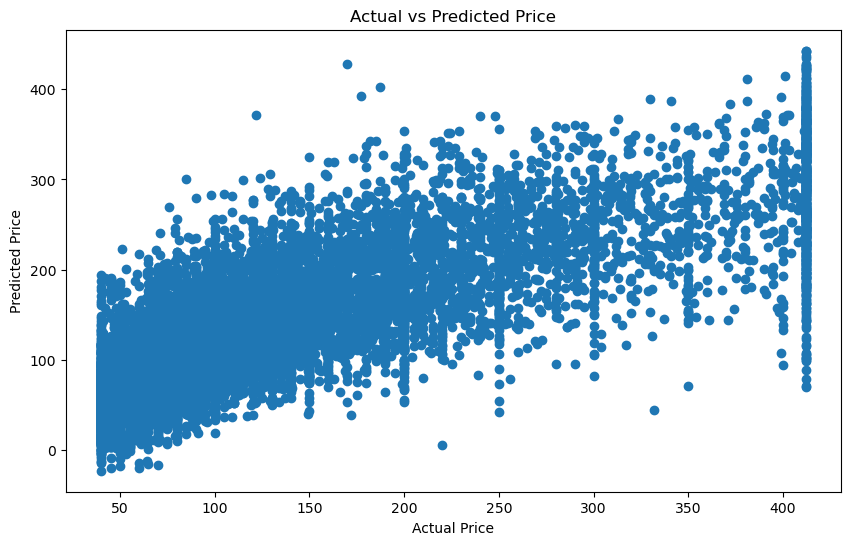

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


columns_to_drop = ['maximum_nights', 'calculated_host_listings_count_shared_rooms', 'zero_reviews', 'Radiant heating', 
                   'Outdoor dining area', 'Security cameras on property', 'Outdoor furniture', 'Rice maker', 'hot tub', 
                   'Bread maker', 'Building staff', 'sound system', 'Sound system', 'Board games', 'gym', 'game console',
                   'Portable heater', 'Safe', 'Lock on bedroom door', 'Babysitter recommendations', 'pool', 
                   'exercise equipment', 'bbq', 'High chair', 'Piano', 'neighbourhood_Bourse', 'neighbourhood_Gobelins',
                   'neighbourhood_Hôtel-de-Ville', 'neighbourhood_Louvre', 'neighbourhood_Luxembourg',
                   'neighbourhood_Observatoire', 'neighbourhood_Palais-Bourbon', 'neighbourhood_Panthéon', 
                   'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Élysée', 'property_type_Hotel', 
                   'property_type_House', 'property_type_Other', 'room_type_Hotel room', 'room_type_Shared room','latitude','longitude']
regressiondata = data_copy_clean.drop(columns_to_drop, axis=1)

# Split the data into features (X) and target variable (y)
X = regressiondata.drop('price', axis=1)
y = regressiondata['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)


# Create a dictionary to store coefficients and their corresponding features
coefficients = {feature: coef for feature, coef in zip(X.columns, model.coef_)}

# Sort the coefficients in descending order based on their absolute values
sorted_coefficients = sorted(coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Print sorted coefficients
print("Sorted Coefficients (Feature Importances):")
for feature, coef in sorted_coefficients:
    print(feature, ':', coef)


# Plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


Mean Squared Error (MSE): 2461.009512134092
Root Mean Squared Error (RMSE): 49.60856289123977
R-squared (R2): 0.7497073670841135
Mean Absolute Error (MAE): 33.88291008044185


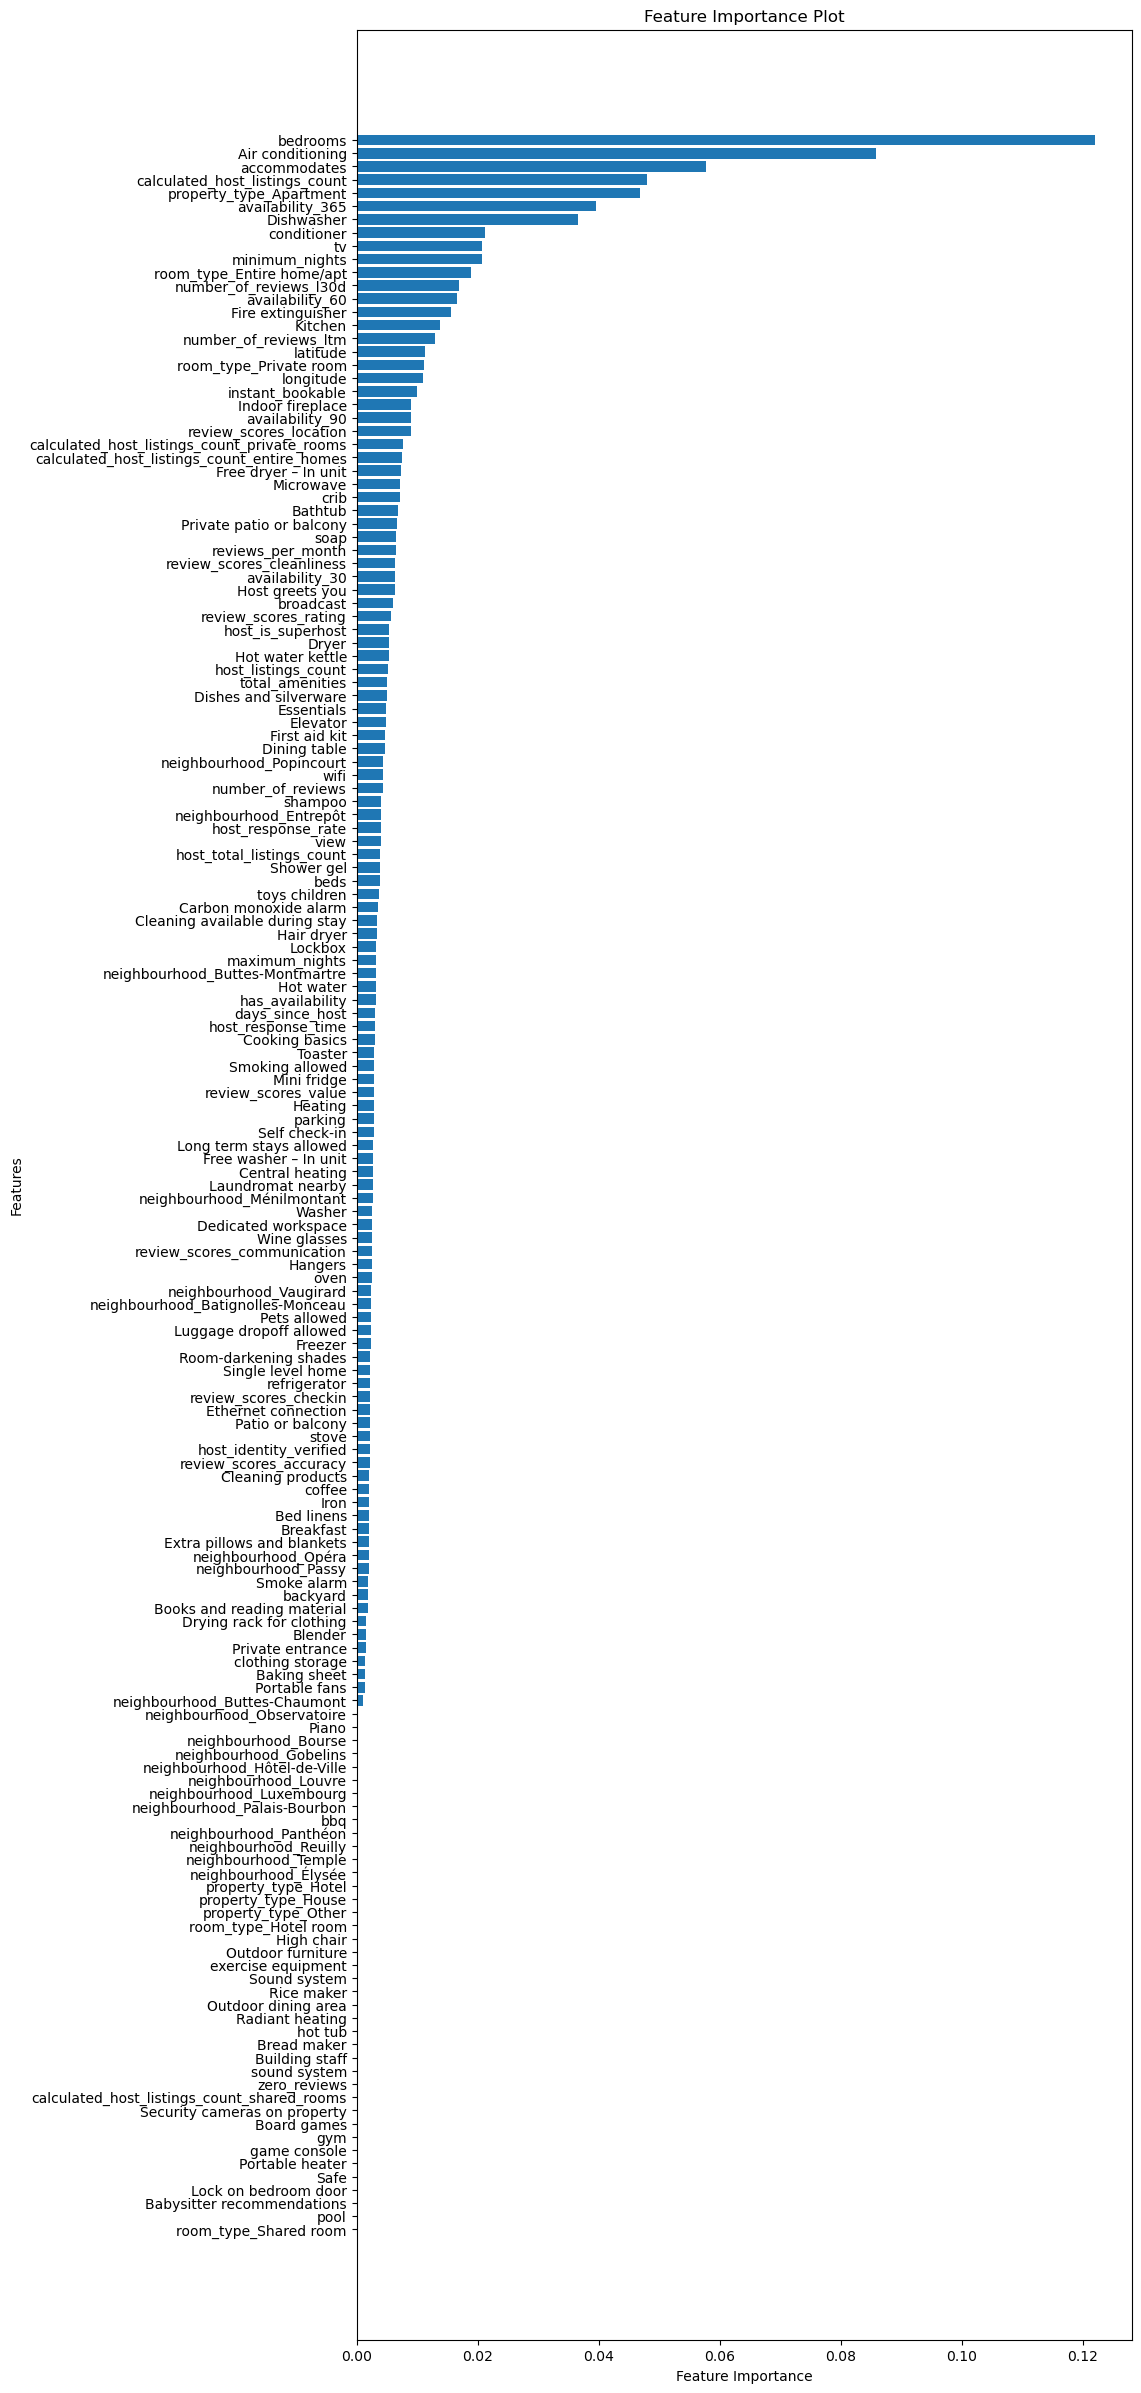

In [75]:
!pip install pandas scikit-learn xgboost matplotlib


import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

columns_to_drop = ['bathrooms']
xgbdata = data_copy_clean.drop(columns_to_drop, axis=1)


# Split the data into features (X) and target variable (y)
X = xgbdata.drop('price', axis=1)
y = xgbdata['price']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate XGBoost Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print performance metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature Importances
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

# Plot feature importances
plt.figure(figsize=(10, 30))
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()


In [83]:
# Backward feature selection
selected_features = list(X.columns)
removed_features = list()
for feature in X.columns:
    # Temporarily remove the feature
    remaining_features = selected_features.copy()
    remaining_features.remove(feature)
    
    # Train model without the removed feature
    model = xgb.XGBRegressor()
    model.fit(X_train[remaining_features], y_train)
    
    # Evaluate performance
    y_pred = model.predict(X_test[remaining_features])
    backwardrmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # If performance improves, update selected features
    if backwardrmse < (rmse+0.01):
        selected_features = remaining_features
        rmse = backwardrmse
        print(f"Feature '{feature}' removed. RMSE: {rmse}")
        removed_features.append(feature)
    else:
        print(f"Feature '{feature}' kept. RMSE: {rmse}")

print("\nFinal selected features:", selected_features)
print("removed features:", removed_features)


Feature 'host_response_time' kept. RMSE: 48.95416832089763
Feature 'host_response_rate' kept. RMSE: 48.95416832089763
Feature 'host_is_superhost' kept. RMSE: 48.95416832089763
Feature 'host_listings_count' kept. RMSE: 48.95416832089763
Feature 'host_total_listings_count' kept. RMSE: 48.95416832089763
Feature 'host_identity_verified' kept. RMSE: 48.95416832089763
Feature 'latitude' kept. RMSE: 48.95416832089763
Feature 'longitude' kept. RMSE: 48.95416832089763
Feature 'accommodates' kept. RMSE: 48.95416832089763
Feature 'bedrooms' kept. RMSE: 48.95416832089763
Feature 'beds' kept. RMSE: 48.95416832089763
Feature 'minimum_nights' kept. RMSE: 48.95416832089763
Feature 'maximum_nights' removed. RMSE: 48.95416832089763
Feature 'has_availability' kept. RMSE: 48.95416832089763
Feature 'availability_30' kept. RMSE: 48.95416832089763
Feature 'availability_60' kept. RMSE: 48.95416832089763
Feature 'availability_90' kept. RMSE: 48.95416832089763
Feature 'availability_365' kept. RMSE: 48.954168320


Performance metrics with filtered features:
Mean Squared Error (MSE): 2426.3866029014775
Root Mean Squared Error (RMSE): 49.258365816391816
R-squared (R2): 0.7532286290167924
Mean Absolute Error (MAE): 33.80564405512795


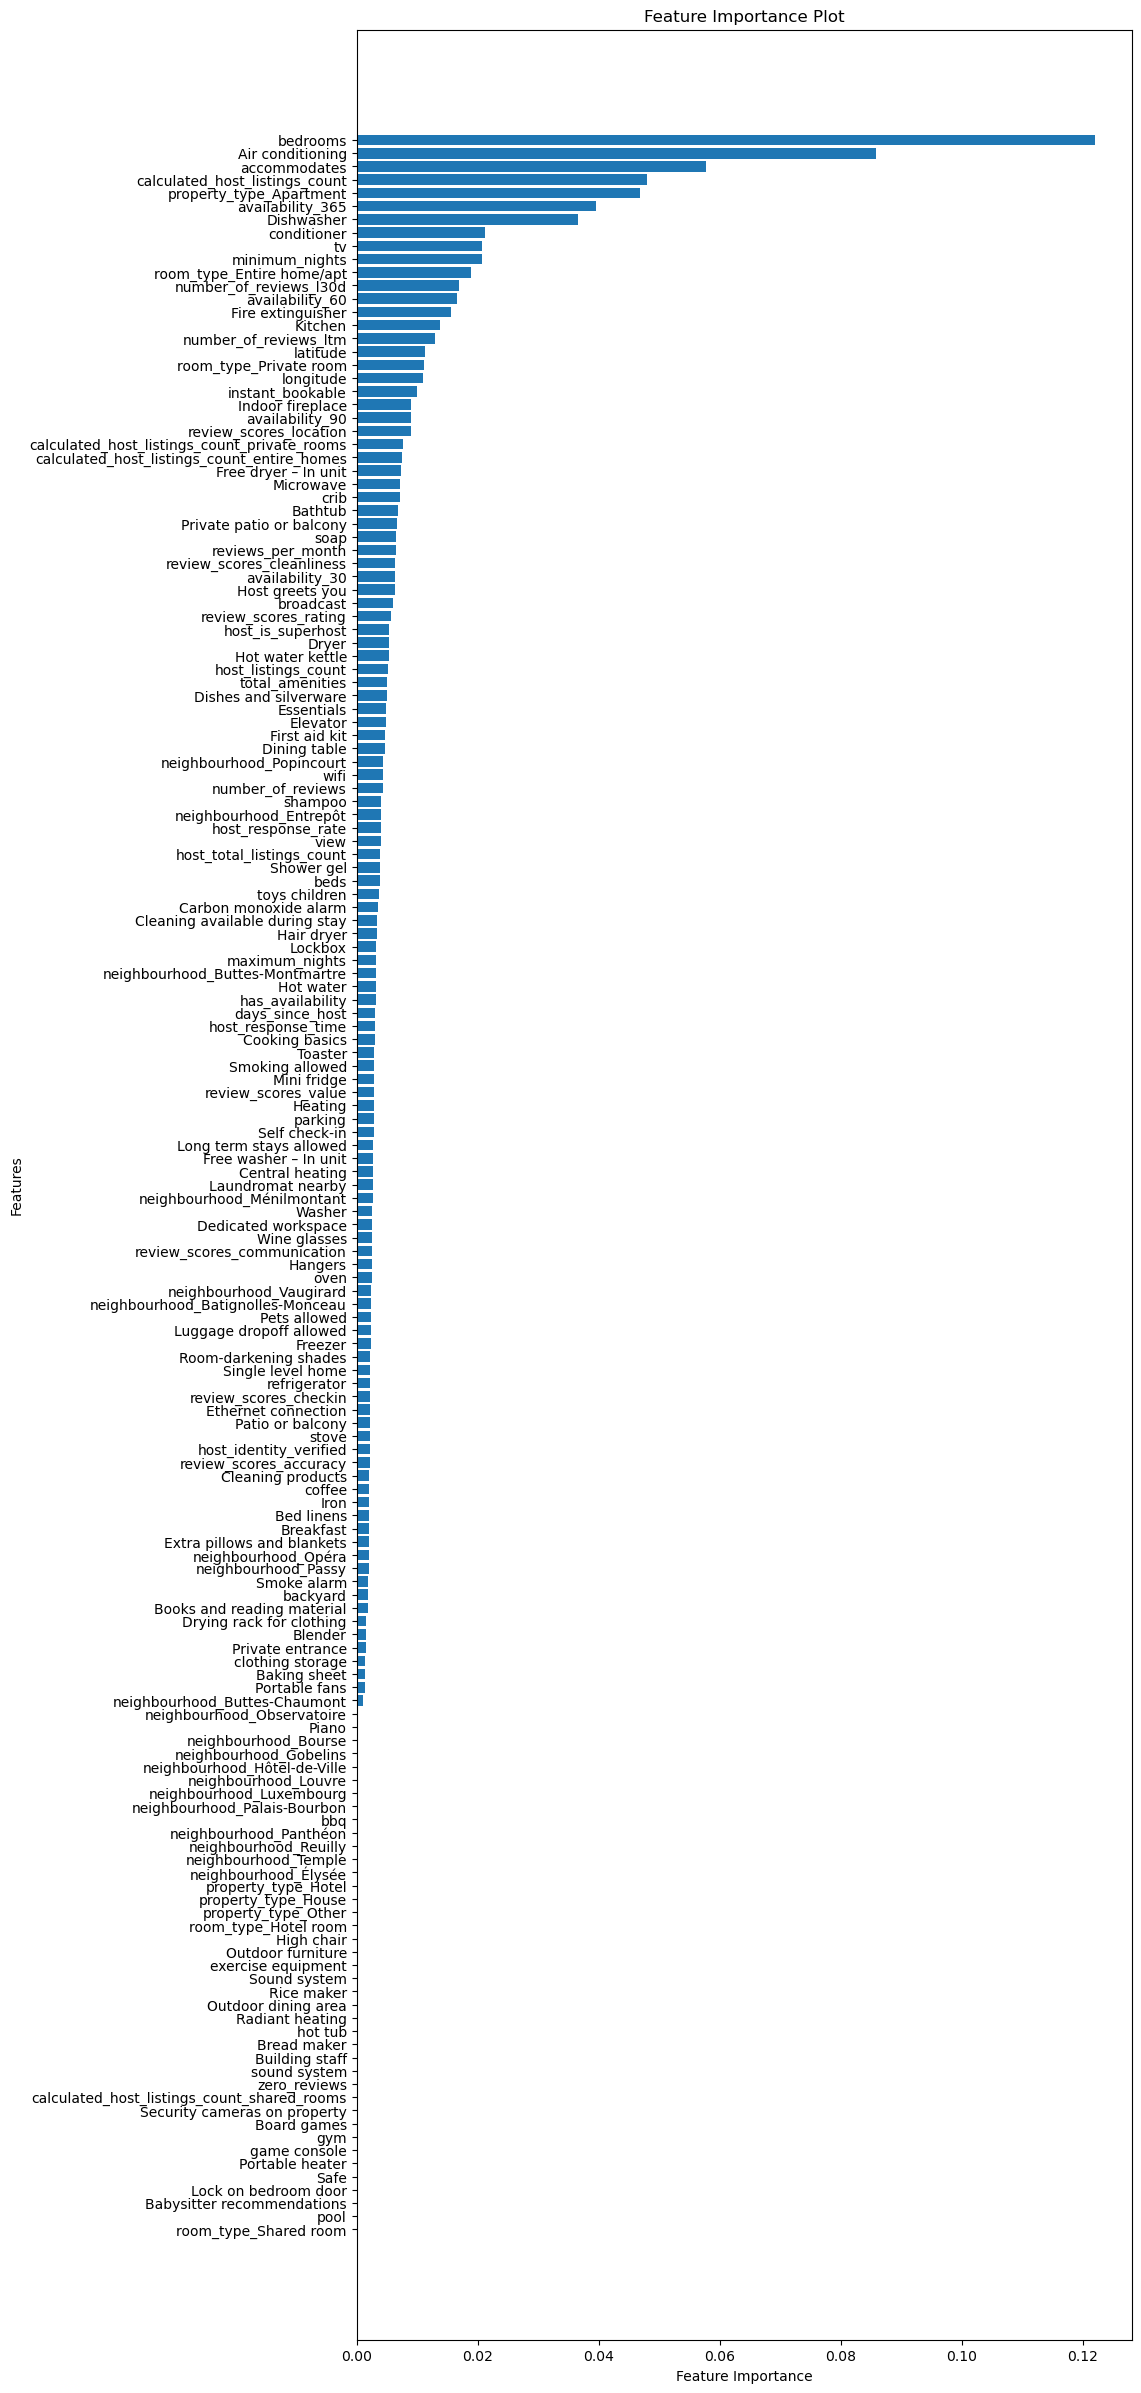

In [76]:

X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

# Train a new XGBoost model with filtered features
model_filtered = xgb.XGBRegressor()
model_filtered.fit(X_train_filtered, y_train)

# Predict on the test set with filtered features
y_pred_filtered = model_filtered.predict(X_test_filtered)

# Calculate performance metrics with filtered features
mse_filtered = mean_squared_error(y_test, y_pred_filtered)
rmse_filtered = mean_squared_error(y_test, y_pred_filtered, squared=False)
r2_filtered = r2_score(y_test, y_pred_filtered)
mae_filtered = mean_absolute_error(y_test, y_pred_filtered)

# Print performance metrics with filtered features
print("\nPerformance metrics with filtered features:")
print("Mean Squared Error (MSE):", mse_filtered)
print("Root Mean Squared Error (RMSE):", rmse_filtered)
print("R-squared (R2):", r2_filtered)
print("Mean Absolute Error (MAE):", mae_filtered)

# Feature Importances
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

# Plot feature importances
plt.figure(figsize=(10, 30))
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()




Performance metrics with filtered features:
Mean Squared Error (MSE): 2764.8288924905846
Root Mean Squared Error (RMSE): 52.58164026055658
R-squared (R2): 0.7188079527318472
Mean Absolute Error (MAE): 35.7944839251138


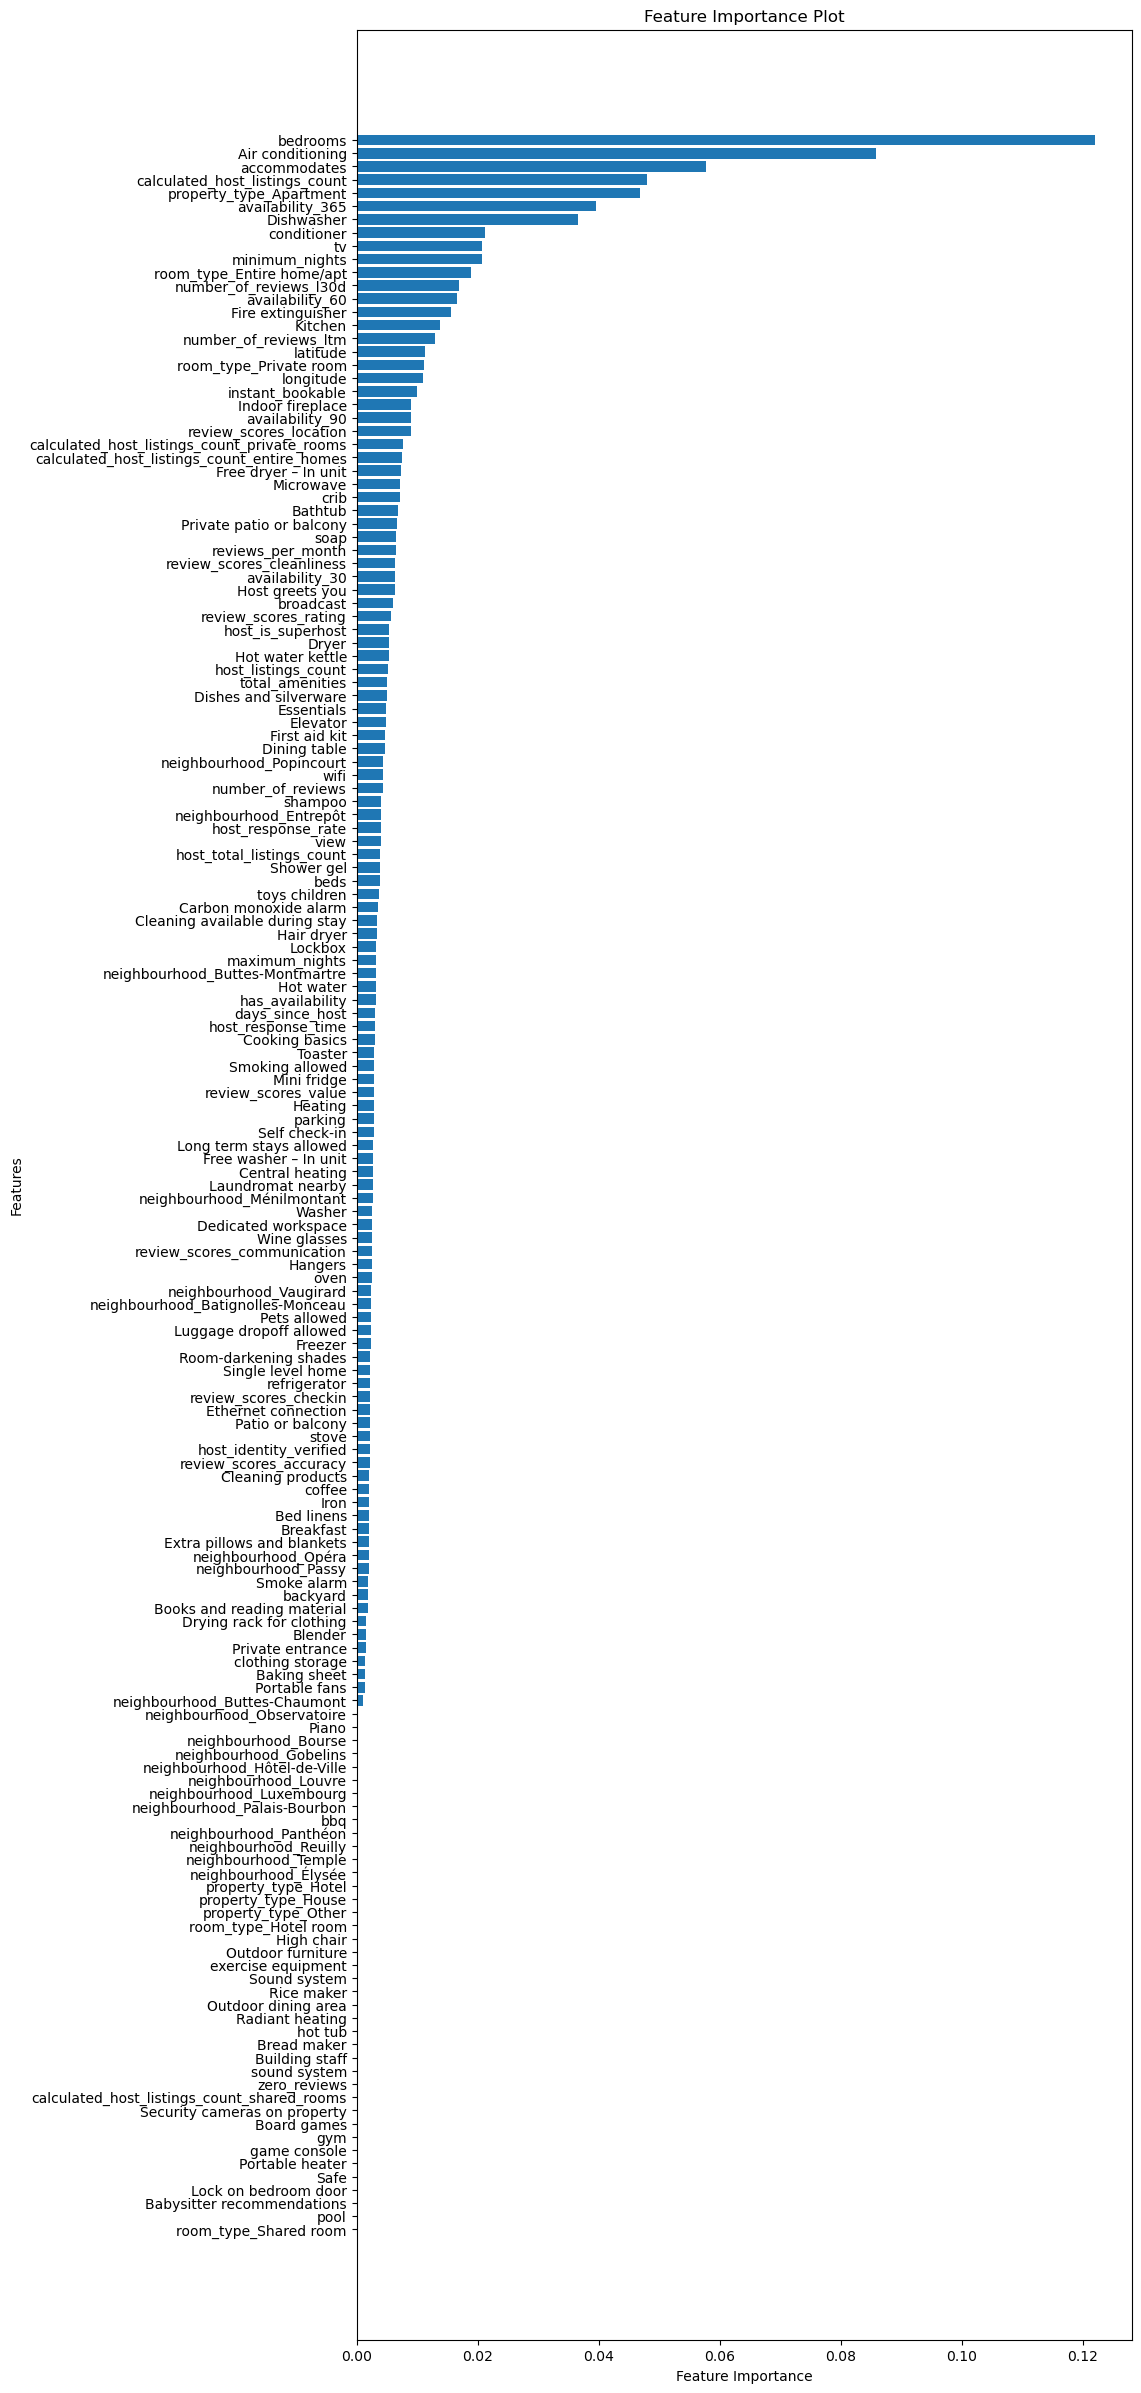


Dropped Features (Importance < 0.01):
Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_identity_verified', 'beds', 'maximum_nights', 'has_availability',
       'availability_30',
       ...
       'neighbourhood_Popincourt', 'neighbourhood_Reuilly',
       'neighbourhood_Temple', 'neighbourhood_Vaugirard',
       'neighbourhood_Élysée', 'property_type_Hotel', 'property_type_House',
       'property_type_Other', 'room_type_Hotel room', 'room_type_Shared room'],
      dtype='object', length=140)


In [78]:
# Filter out features with importance less than 0.01
selected_features_treshhold = X.columns[feature_importance >= 0.01]
X_train_treshhold = X_train[selected_features_treshhold]
X_test_treshhold = X_test[selected_features_treshhold]
dropped_features = X.columns[feature_importance < 0.01]

# Train a new XGBoost model with filtered features
model_filtered_treshhold = xgb.XGBRegressor()
model_filtered_treshhold.fit(X_train_treshhold, y_train)

# Predict on the test set with filtered features
y_pred_treshhold = model_filtered_treshhold.predict(X_test_treshhold)

# Calculate performance metrics with filtered features
mse_filtered_treshhold = mean_squared_error(y_test, y_pred_treshhold)
rmse_filtered_treshhold = mean_squared_error(y_test, y_pred_treshhold, squared=False)
r2_filtered_treshhold = r2_score(y_test, y_pred_treshhold)
mae_filtered_treshhold = mean_absolute_error(y_test, y_pred_treshhold)

# Print performance metrics with filtered features
print("\nPerformance metrics with filtered features:")
print("Mean Squared Error (MSE):", mse_filtered_treshhold)
print("Root Mean Squared Error (RMSE):", rmse_filtered_treshhold)
print("R-squared (R2):", r2_filtered_treshhold)
print("Mean Absolute Error (MAE):", mae_filtered_treshhold)

# Feature Importances
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

# Plot feature importances
plt.figure(figsize=(10, 30))
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()



# Print dropped features
print("\nDropped Features (Importance < 0.01):")
print(dropped_features)